In [53]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import plotly.express as px
from matplotlib import pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
from io import BytesIO
import requests
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

## Step 1: Load and Prepare Data

We begin by loading the balanced metadata CSV file, which contains information about each image and its labels. We then balance the dataset to focus only on images where an animal is present.

In [54]:
# ✅ Step 1: Load the balanced dataset
import pandas as pd

df_cleaned = pd.read_csv("balanced_metadata.csv")
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39588 entries, 0 to 39587
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      39588 non-null  int64 
 1   id              39588 non-null  object
 2   datetime        39588 non-null  object
 3   file_name       39588 non-null  object
 4   seq_id          39588 non-null  object
 5   frame_num       39588 non-null  int64 
 6   seq_num_frames  39588 non-null  int64 
 7   location        39588 non-null  object
 8   category_id     39588 non-null  int64 
 9   has_animal      39588 non-null  int64 
 10  species         39588 non-null  object
dtypes: int64(5), object(6)
memory usage: 3.3+ MB


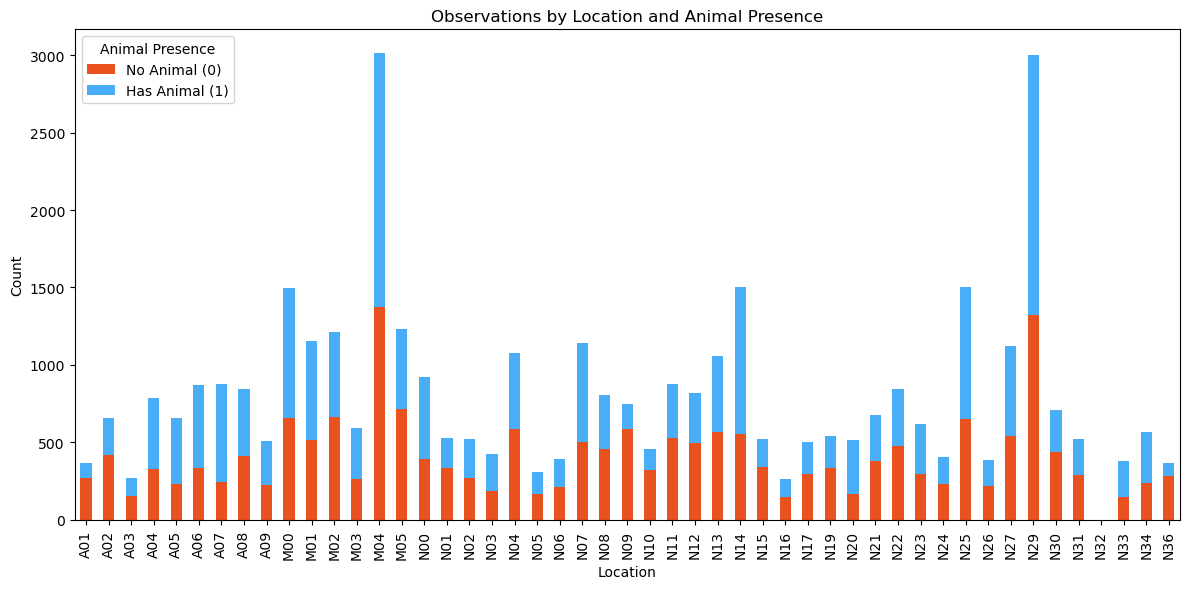

In [55]:
# ✅ Step 2: Group by location and animal presence
df_locations = df_cleaned.groupby(["location", "has_animal"]).size().reset_index(name="count")
df_pivot = df_locations.pivot(index="location", columns="has_animal", values="count").fillna(0)

# ✅ Step 3: Plot
df_pivot.plot(kind='bar', stacked=True, color=["#E9511F", "#49AEF7"], figsize=(12, 6))
plt.title("Observations by Location and Animal Presence")
plt.xlabel("Location")
plt.ylabel("Count")
plt.legend(["No Animal (0)", "Has Animal (1)"], title="Animal Presence")
plt.tight_layout()
plt.show()

In [56]:
# balence the data
df_empty=df_cleaned[df_cleaned.has_animal==0]
df_empty = df_empty.reset_index(drop=True)
df_animal=df_cleaned[df_cleaned.has_animal==1]
df_animal=df_animal.reset_index(drop=True)

## Step 2: Define Feature Extractor and Image Preprocessing

Using a pretrained ResNet18 model, we remove the final classification layer and use it to extract deep features from the images. The transform resizes and normalizes each image to match the input format expected by ResNet.

In [57]:
# Define the feature extractor (ResNet18 without final layer)
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
resnet.eval()

# Image transform (match ResNet's expectations)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Extract features from a list of image paths
def extract_features(df, image_base_dir="https://lilawildlife.blob.core.windows.net/lila-wildlife/orinoquia-camera-traps/public/"):
    features = []
    valid_indices = []

    for i in tqdm(range(len(df))):
        file_path = os.path.join(image_base_dir, df.file_name.iloc[i])

        try:
            response = requests.get(file_path, timeout=10)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert("RGB")

            img_tensor = transform(img).unsqueeze(0)
            with torch.no_grad():
                feature_vec = resnet(img_tensor).squeeze().numpy()

            features.append(feature_vec)
            valid_indices.append(i)

        except Exception as e:
            print(f"❌ Failed to process {file_path}: {e}")
            continue

    return np.array(features), df.iloc[valid_indices].reset_index(drop=True)

## Step 3: Extract Features from Sampled Images

To keep the runtime and memory manageable, we randomly sample 300 images from the animal-only subset. Features are extracted from each image using the ResNet-based pipeline defined above.

In [58]:
# Sample a small number of rows to test PCA + KMeans pipeline
df_sample = df_animal.sample(n=300, random_state=42).reset_index(drop=True)

In [59]:
animal_features, df_animal_valid = extract_features(df_sample)

100%|█████████████████████████████████████████| 300/300 [04:39<00:00,  1.07it/s]


## Step 4: PCA for Dimensionality Reduction

We apply Principal Component Analysis (PCA) to reduce the 512-dimensional image features into 2D. This allows us to visualize the image data and understand the structure of the feature space.

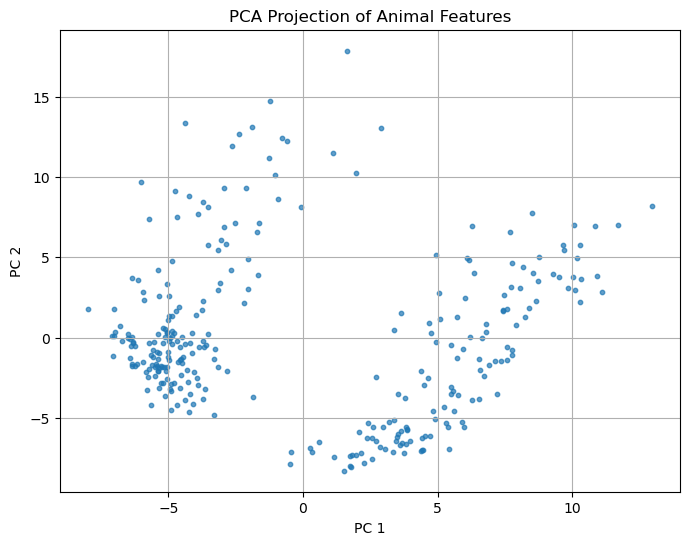

In [60]:
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(animal_features)

# Visualize the PCA projection
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], s=10, alpha=0.7)
plt.title("PCA Projection of Animal Features")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()

## Step 5: K-Means Clustering

We apply K-Means clustering (with 5 clusters) to the PCA-transformed features. The resulting clusters represent groups of similar images in the feature space.

/Users/bretgeyer/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


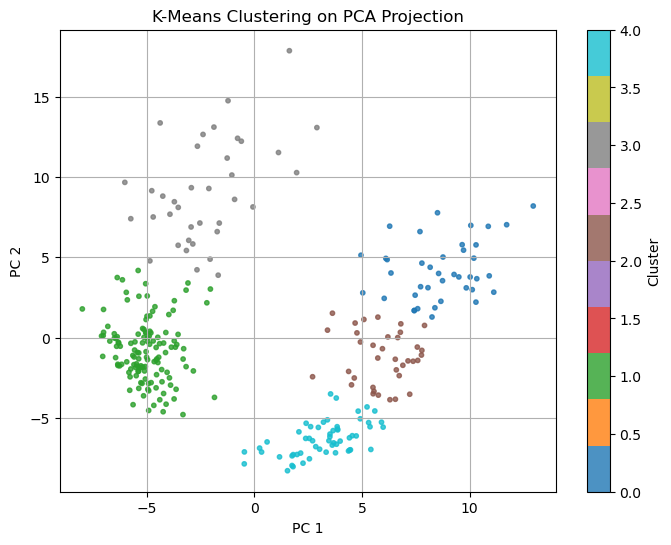

In [61]:
# Fit K-Means on the PCA-transformed features
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(features_pca)

# Plot with cluster coloring
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='tab10', s=10, alpha=0.8)
plt.title("K-Means Clustering on PCA Projection")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.colorbar(label="Cluster")
plt.show()

## Step 6: Analyze Cluster Composition

We add the cluster labels back to the metadata and analyze the species composition within each cluster. This helps us interpret what kinds of animals or environments the clusters represent.

In [62]:
# Add cluster labels back to the valid DataFrame
df_animal_valid["cluster"] = cluster_labels

# Preview a few rows
df_animal_valid[["file_name", "species", "location", "cluster"]].head()

,file_name,species,location,cluster
0,M03/100EK113/03250414.JPG,unknown_bird,M03,1
1,N14/102EK113/04240044.JPG,collared_peccary,N14,1
2,A08/101EK113/02200399.JPG,spotted_paca,A08,1
3,M00/102EK113/04290208.JPG,collared_peccary,M00,2
4,N14/104EK113/07110510.JPG,black_agouti,N14,0


In [63]:
# Attach cluster labels to valid dataframe
df_animal_valid["cluster"] = cluster_labels

# View species count in each cluster
species_by_cluster = df_animal_valid.groupby(["cluster", "species"]).size().unstack(fill_value=0)

# Show top 10 rows
species_by_cluster.head(10)

species,amazonian_motmot,black_agouti,cattle,collared_peccary,crab-eating_fox,domestic_horse,giant_anteater,human,lowland_tapir,northern_amazon_red_squirrel,...,spixs_guan,spotted_paca,tayra,unknown,unknown_armadillo,unknown_bird,unknown_cervid,unknown_possum,white-lipped_peccary,white-tailed_deer
cluster,,,,,,,,,,,,,,,,,,,,,
0,0,5,2,15,0,3,0,2,0,0,...,0,0,0,1,1,1,0,1,6,1
1,1,23,2,25,1,2,3,4,2,0,...,1,17,0,0,11,9,1,4,4,1
2,0,5,3,8,0,4,0,2,0,0,...,0,2,0,1,2,1,0,0,2,0
3,0,1,1,20,0,0,0,1,0,0,...,0,4,0,0,1,2,0,1,3,0
4,0,14,0,11,0,0,1,1,1,1,...,1,2,1,0,2,5,0,0,5,0


## Step 7: Visualize Species Distribution with Heatmap

The heatmap below shows how different species are distributed across the 5 clusters. This can reveal patterns like which species often co-occur or appear in similar environments.

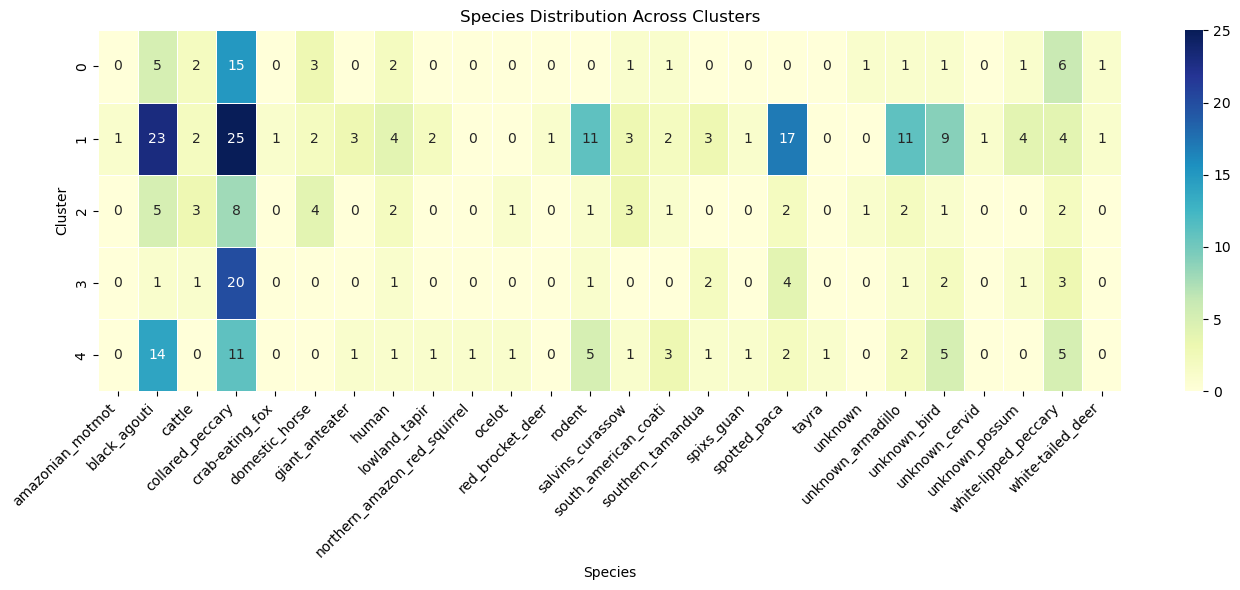

In [64]:
# Set up the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(species_by_cluster, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)

plt.title("Species Distribution Across Clusters")
plt.xlabel("Species")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Conclusion

Through this analysis, we successfully used a pretrained ResNet18 model to extract features from a sample of camera trap images, applied PCA for dimensionality reduction, and performed K-Means clustering to uncover patterns in the data. The clusters revealed meaningful groupings of species and image characteristics, which we visualized through a heatmap showing species distribution across clusters. This approach demonstrates the potential of combining deep learning feature extraction with unsupervised learning to explore large-scale wildlife image datasets.